# What is Quancolutional NN?

Here we present Quantum version of Convolutional neural networks.To do so we briefly explain some steps we will use in this tutorial

1.   Installing,importing of important packages along with initialisation of our model parameters and loading our data in required form
2.   we create a quantum circuit to encode 4 bits of data

1.   Using circuit we created we pass image through QCNN and obtain convulated image data
2.   We pass tranfomed data through our model and then compaute accuracy of our model






**The main difference with respect to a classical convolution:**

In principle, a quantum circuit can generate highly complex kernels, the computation of which is classically intractable.

In this work, initial data set first encodes in quantum state, then evovles through a quantum random circuit and then after measurment multiple classical filter each lower dimention are created. A proper Classical NN can be implemented afterward.

In [1]:
! pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.6 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

##**Initialization**##


**Here we set model paramters and we can change them to give us best performance**

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50   # Size of the train dataset
n_test = 30   # Size of the test dataset

import os
# Define the save path
SAVE_PATH = '../_static/' # Data saving folder
# Create the directory if it does not exist
os.makedirs(SAVE_PATH, exist_ok=True)

PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

1- loading MNSIT data set

2- separating trainig data and test data from dataset

3- normalize the dataset

4- add convolutional channel to arrayed dataset

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Splitting into train and test data
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
np.shape(train_images)

(50, 28, 28, 1)

1- Create a quantum node

2- Create a quantum circuit that consists of

*   **an encoding layer which rotates first 4 qubits around y axis by some angle**
*   **a random quantum circuit to introduce randomness to encoded data(form of data augmentation)**
*   **measurment on output qubits on computational basis to calculate  expectation values of pauli matrix $Z$, i.e., $\langle Z\rangle$.**



  


In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
      qml.RY(np.pi * phi[j], wires=j) #These operations rotate each of the first four qubits in the circuit by the specified angles around the Y-axis
    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

**The demonstartion of the circuit**

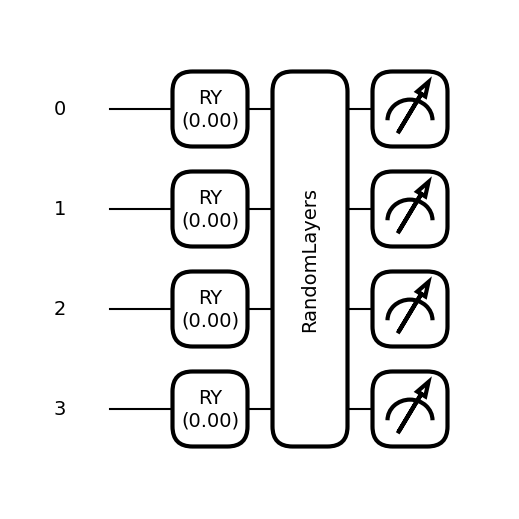

In [7]:
phii = [0,0,0,0]
fig, ax = qml.draw_mpl(circuit, decimals=2)(phii)
plt.show()

**Quanv function applies a quantum circuit to 2x2 pixel regions (also called patches) of an input image, treating each 2x2 region as input to the quantum circuit. The function loops over the image using a step size of 2 for both rows (j) and columns (k). This ensures that it processes every 2x2 region of the image.The output of the quantum circuit (which is the expectation values of certain quantum measurements) is then stored in a new output image, forming what can be thought of as a quantum convolutional layer.**

In [8]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

**Now that we have qcnn layer.we pass our test and train data through layer and save it**

In [9]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


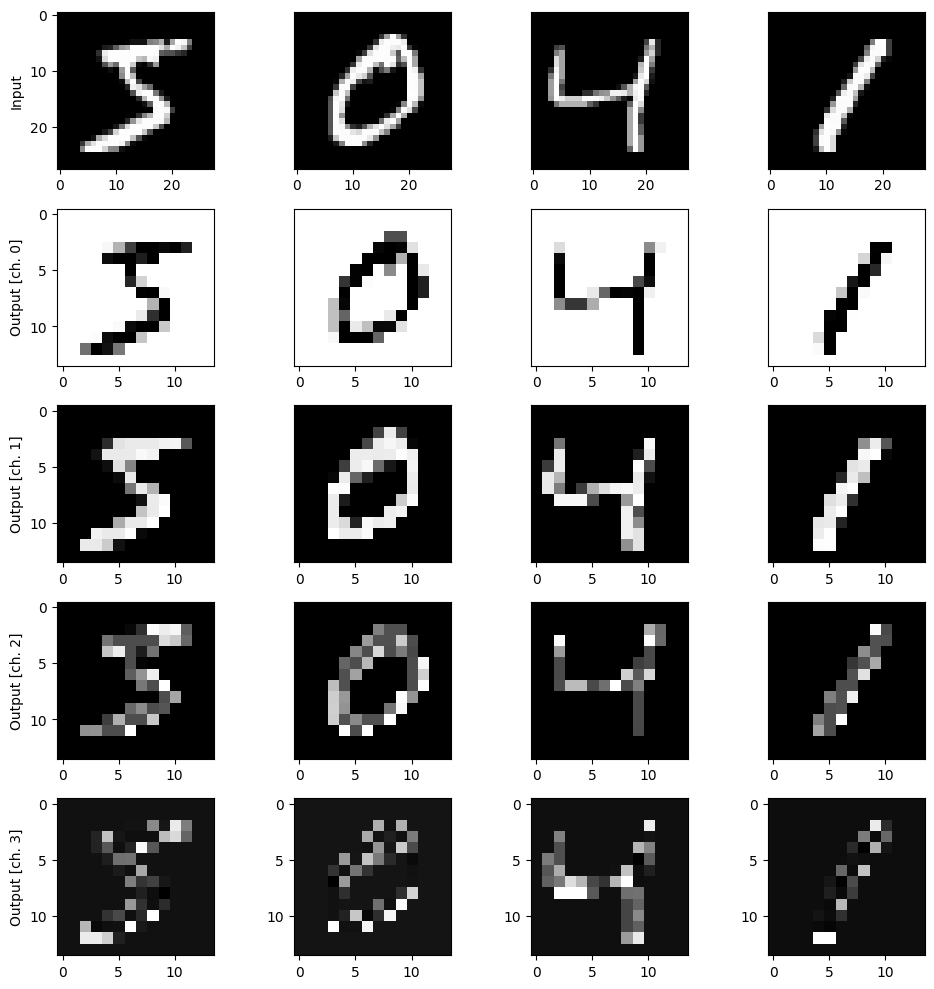

In [10]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

**Now we define our custom classic model to train our data along with loss fuvnctions and optimizers**

In [11]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        #keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

**First we we train using quantum encoded data and then classical non encoded so taht we can compare whcih model works best**

In [12]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,#encoded data
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 3s - 227ms/step - accuracy: 0.0600 - loss: 2.7247 - val_accuracy: 0.3000 - val_loss: 2.1502
Epoch 2/30
13/13 - 0s - 12ms/step - accuracy: 0.3200 - loss: 1.9435 - val_accuracy: 0.4000 - val_loss: 1.9298
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5800 - loss: 1.6303 - val_accuracy: 0.4000 - val_loss: 1.7976
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.7200 - loss: 1.3311 - val_accuracy: 0.4333 - val_loss: 1.6875
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8600 - loss: 1.1010 - val_accuracy: 0.5000 - val_loss: 1.5794
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.9000 - loss: 0.9201 - val_accuracy: 0.5333 - val_loss: 1.4968
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.7735 - val_accuracy: 0.6000 - val_loss: 1.4313
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.6572 - val_accuracy: 0.6000 - val_loss: 1.3738
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.5624 - val_accuracy: 0.6000 - val_loss: 1.3246
Epoch 10/30


In [13]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,#non encoded data
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 3s - 213ms/step - accuracy: 0.1600 - loss: 2.3672 - val_accuracy: 0.3000 - val_loss: 2.1859
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.3800 - loss: 1.9466 - val_accuracy: 0.3333 - val_loss: 2.0226
Epoch 3/30
13/13 - 0s - 7ms/step - accuracy: 0.6400 - loss: 1.6559 - val_accuracy: 0.3667 - val_loss: 1.8805
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.7600 - loss: 1.4203 - val_accuracy: 0.4333 - val_loss: 1.7560
Epoch 5/30
13/13 - 0s - 8ms/step - accuracy: 0.8600 - loss: 1.2251 - val_accuracy: 0.5667 - val_loss: 1.6514
Epoch 6/30
13/13 - 0s - 7ms/step - accuracy: 0.8800 - loss: 1.0632 - val_accuracy: 0.6667 - val_loss: 1.5662
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9000 - loss: 0.9287 - val_accuracy: 0.6667 - val_loss: 1.4970
Epoch 8/30
13/13 - 0s - 10ms/step - accuracy: 0.9000 - loss: 0.8163 - val_accuracy: 0.6667 - val_loss: 1.4400
Epoch 9/30
13/13 - 0s - 11ms/step - accuracy: 0.9000 - loss: 0.7218 - val_accuracy: 0.6000 - val_loss: 1.3922
Epoch 10/30
13

**Now we compare results using plots so we can visually compare which model performs better**

<ipython-input-14-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


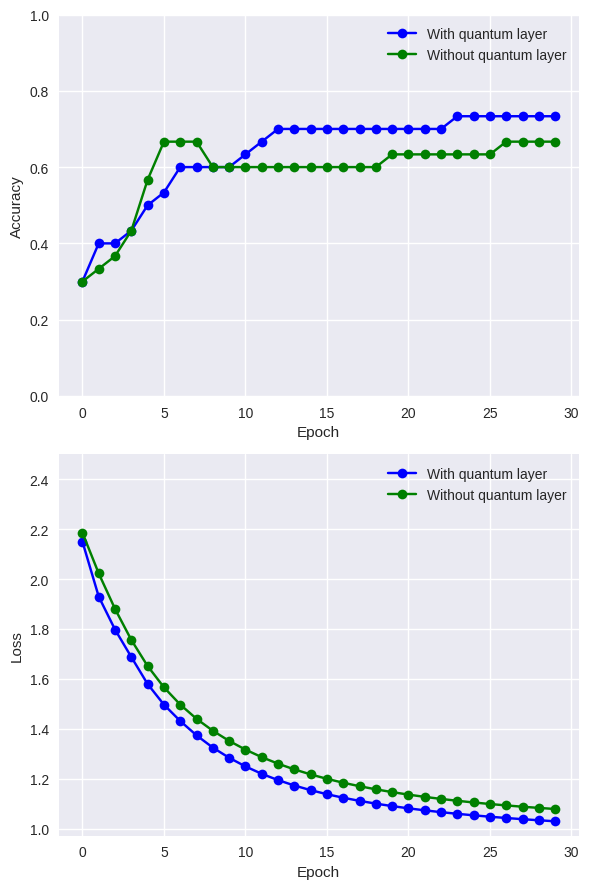

In [14]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# **We can clearly see classical data performs better than quantum encoded data,lets see what might be reasons**

### 1. **Classical Models Are More Developed**
   - **More Experience**: Scientists and engineers have been working on classical models for many years, so they've figured out how to make them work really well.
   - **Better Tools**: There are lots of software libraries, like TensorFlow and PyTorch, that make it easy to build and train classical models.

### 2. **Quantum Computers Are Still New**
   - **Noisy and Unstable**: Today's quantum computers aren't perfect—they make errors and are unstable, which can mess up the results.
   - **Not Enough Qubits**: Quantum computers don't have enough "qubits" (quantum bits) to handle big, complex problems that classical models can easily tackle.

### 3. **Quantum Algorithms Are Limited**
   - **Still Being Figured Out**: Quantum machine learning is a new field, and researchers are still trying to understand the best ways to use quantum computers for these tasks.
   - **Hard to Combine with Classical Models**: Sometimes, quantum models need to be combined with classical models to work well, but making them work together is tricky and often not worth the effort.

### 4. **Training Quantum Models Is Hard**
   - **Hard to Optimize**: Classical models have well-known methods for training (like backpropagation), but training quantum models is still difficult and doesn't always work well.
   - **Data Challenges**: Classical models are great at handling large amounts of data. Quantum models struggle with this because getting data into a quantum computer is complex.

### 5. **Classical Models Are Easier to Use**
   - **Works on Any Computer**: Classical models run on regular computers that everyone has, while quantum computers are rare, expensive, and not as easy to access.
   - **Faster and Cheaper**: Classical computers can run models quickly and cheaply. Quantum computers are slower and more expensive to use right now.



### Here we shows model when we add a layer of relu or leaky relu functions sometimes gives better accuracy and less loss but most important result to notice is it **sometimes** our model with quantum encoded data outperforms one with classic data.




In [19]:
def LRModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
      #  keras.layers.Dense(128),  # Dense layer
      #  LeakyReLU(alpha=0.03),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [20]:
q_model = LRModel()

q_history = q_model.fit(
    q_train_images,#encoded data
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 165ms/step - accuracy: 0.1400 - loss: 2.7486 - val_accuracy: 0.1667 - val_loss: 2.1461
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.5600 - loss: 1.6189 - val_accuracy: 0.6667 - val_loss: 1.6113
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.8600 - loss: 0.9953 - val_accuracy: 0.6667 - val_loss: 1.4459
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.9400 - loss: 0.6421 - val_accuracy: 0.7667 - val_loss: 1.2937
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.4011 - val_accuracy: 0.7333 - val_loss: 1.1638
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.2599 - val_accuracy: 0.7000 - val_loss: 1.0977
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.1730 - val_accuracy: 0.7000 - val_loss: 1.0783
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.1270 - val_accuracy: 0.7333 - val_loss: 1.0504
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.0961 - val_accuracy: 0.7333 - val_loss: 1.0322
Epoch 10/30
13/1

In [21]:
c_model = LRModel()

c_history = c_model.fit(
    train_images,#non encoded data
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 3s - 264ms/step - accuracy: 0.2000 - loss: 2.2099 - val_accuracy: 0.4000 - val_loss: 2.0186
Epoch 2/30
13/13 - 3s - 200ms/step - accuracy: 0.7200 - loss: 1.4087 - val_accuracy: 0.4667 - val_loss: 1.7312
Epoch 3/30
13/13 - 0s - 11ms/step - accuracy: 0.9600 - loss: 0.9402 - val_accuracy: 0.4667 - val_loss: 1.5132
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.5983 - val_accuracy: 0.6000 - val_loss: 1.3560
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.3821 - val_accuracy: 0.6000 - val_loss: 1.2468
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.2481 - val_accuracy: 0.5667 - val_loss: 1.1718
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.1686 - val_accuracy: 0.6333 - val_loss: 1.1211
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.1192 - val_accuracy: 0.6333 - val_loss: 1.0846
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.0885 - val_accuracy: 0.6333 - val_loss: 1.0593
Epoch 10/30
1

<ipython-input-22-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


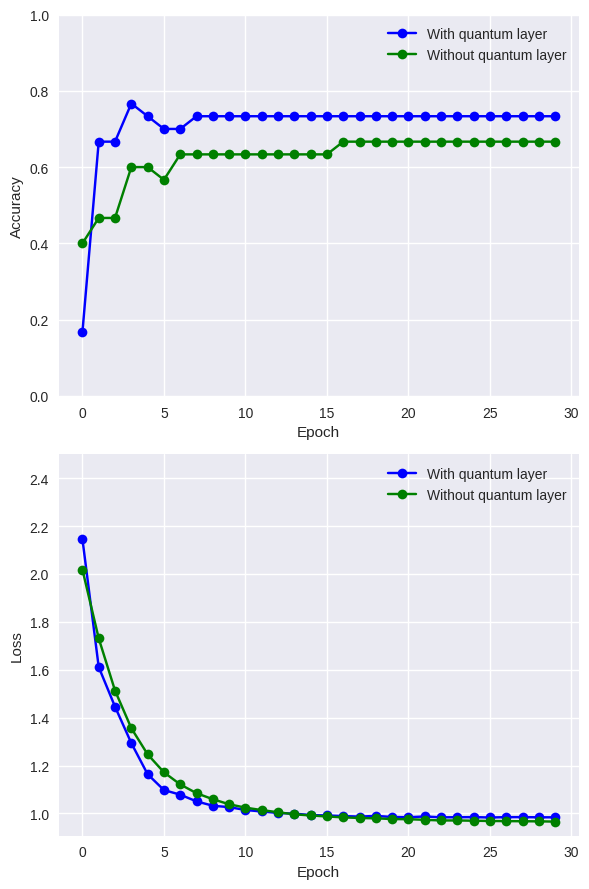

In [22]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

 ### **Summary**
Classical machine learning models are better right now because they're more developed, easier to use, and run on computers we all have. Quantum models are exciting and may become better in the future, but for now, they can't compete with the speed, reliability, and power of classical models.
